# Using EchoClassesDataset()

Miguel Xochicale [@mxochicale](https://github.com/mxochicale)  
Jan2022


## 1.1 Introduction
This notebook presents prototypes to pre-process echocardiography datasets with the use of pytorch features. 

## 1.2 Running notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
## 1.3 References
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 




## 2. Jupyter Notebook

### 2.1 Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from torch.utils.data import DataLoader
from torchvision import transforms, utils

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset

HOME_PATH = os.path.expanduser(f'~')
CONFIG_FILES_PATH= 'repositories/echocardiography/scripts/config_files'
YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, 'config_echo_classes.yml')

with open(YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

### 2.2 Setting variables and loading datasets using pytorch dataloader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define some static transforms, i.e. transforms that apply to the entire dataset.
# These transforms are not augmentation.
pretransform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=config['pretransform_im_size']),
    transforms.ToTensor(),  # this normalizes in
])

# define some transforms for data augmentation: they have all random parameters that
# will change at each epoch.
if config['use_augmentation']:
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5), # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),  # this normalizes in
    ])
else:
    transform=None

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = EchoClassesDataset(main_data_path=config['main_data_path'],
                             participant_videos_list=config['participant_videos_list'],
                             participant_path_json_list=config['participant_path_json_list'],
                             crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
                             number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
                             sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
                             device=device,
                             max_background_duration_in_secs=config['max_background_duration_in_secs'],
                             pretransform=pretransform,
                             transform=transform,
                             use_tmp_storage=True,
                             )


### 2.3 Using dataloader with pre-processing image techniques

Plotting 8 clips  and frames: 
10
   Clip number: 0
   Random index in the segment clip: 28 of n_available_frames 150
   Clip number: 1
   Random index in the segment clip: 138 of n_available_frames 151
   Clip number: 2
   Random index in the segment clip: 106 of n_available_frames 150
   Clip number: 3
   Random index in the segment clip: 96 of n_available_frames 149
   Clip number: 4
   Random index in the segment clip: 30 of n_available_frames 96
   Clip number: 5
   Random index in the segment clip: 20 of n_available_frames 94
   Clip number: 6
   Random index in the segment clip: 61 of n_available_frames 101
   Clip number: 7
   Random index in the segment clip: 67 of n_available_frames 105


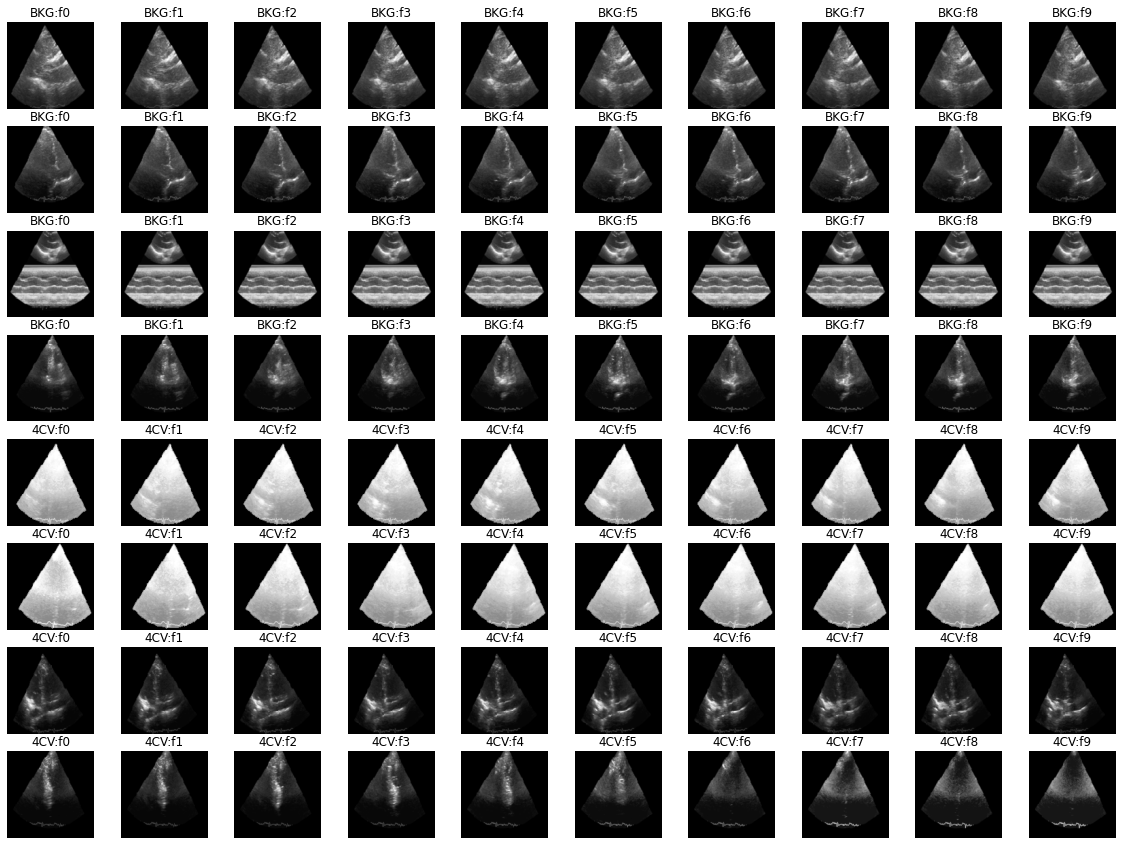

In [3]:
number_of_clips = len(dataset)
print(f'Plotting {number_of_clips} clips  and frames: ')
print(config['number_of_frames_per_segment_in_a_clip'])
labelnames = ('BKG', '4CV') #('B', '4') #


plt.figure(figsize=(20, 15))
subplot_index = 0
for clip_index_i in range(len(dataset)):
    print(f'   Clip number: {clip_index_i}')
    data_idx = dataset[clip_index_i]
    print(f'   Random index in the segment clip: {data_idx[2]} of n_available_frames {data_idx[3]}')

    for frame_i in range(data_idx[0].shape[1]):
        plt.subplot(number_of_clips, data_idx[0].shape[1], subplot_index+1)
        plt.imshow(data_idx[0][0, frame_i, ...].cpu().data.numpy(), cmap='gray')
        # plt.ylabel('{}'.format( clip_index_i  ) )
        plt.axis('off')
        plt.title('{}:f{}'.format(labelnames[data_idx[1]], frame_i))

        subplot_index +=1

plt.show()

